In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black
import ncxt_sxtcnn
from ncxt_sxtcnn import Segmenter

<IPython.core.display.Javascript object>

In [2]:
from ncxt_sxtcnn.sxtcnn.loaders import AmiraLoaderx100
from ncxt_sxtcnn.sxtcnn.models import UNet3D
from ncxt_sxtcnn.sxtcnn.processors import RandomBlockProcessor
from ncxt_sxtcnn.sxtcnn.criteria import CrossEntropyLoss_DiceLoss

<IPython.core.display.Javascript object>

In [3]:
from ncxt_sxtcnn.hxdatabase import Database

db = Database("mockdata/")
membrane = ["membrane"]
nucleus = ["euchromatin", "heterochromatin", "nucleus"]
nucleolus = ["nucleolus"]
hxfiles = db.filelist(membrane, nucleus, nucleolus)
db.dataframe_sel(membrane, nucleus)

mockdata/


C:\Users\axela\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,project,sample,void,void1,nucleus,nucleolus,granule,mitochondria,lipid,endoplasmic reticulum,membrane,ignore
0,pi1,sample_12,0,1,2,3,4,5,6,7,8,9
1,pi2,sample_9,0,,1,5,,3,2,4,6,


<IPython.core.display.Javascript object>

In [4]:
files = db.filelist(membrane, nucleus, nucleolus)
working_directory = "C:/Users/axela/Documents/2020/example_wd/"

<IPython.core.display.Javascript object>

### First net

In [5]:
features = [["*"], nucleus, nucleolus]
loader_args = {"files": files, "features": features}
processor_args = {"block_shape": (32, 32, 32), "binning": 1}
model_args = {
    "num_classes": len(features) + 1,
    "depth": 3,
    "start_filts": 32,
    "dropout": None,
    "instancenorm": True,
}
crit_args = dict()
settings = {"maximum_iterations": 100}

segmenter_base = Segmenter(
    AmiraLoaderx100,
    RandomBlockProcessor,
    UNet3D,
    CrossEntropyLoss_DiceLoss,
    loader_args,
    processor_args,
    model_args,
    crit_args,
    settings,
)
segmenter_base.folder = working_directory
segmenter_base.fold = 0

instance_base = segmenter_base.sxtcnn(0)
instance_base.settings.reset = True
instance_base._init_data()
instance_base.run()

<IPython.core.display.Javascript object>

### Second net

In [6]:
features = [nucleus, nucleolus]
loader_args = {"files": files, "features": features}
processor_args = {"block_shape": (32, 32, 32), "binning": 1}
model_args = {
    "num_classes": len(features) + 1,
    "depth": 3,
    "start_filts": 32,
    "dropout": None,
    "instancenorm": True,
}
crit_args = dict()
settings = {"maximum_iterations": 50}

segmenter = Segmenter(
    AmiraLoaderx100,
    RandomBlockProcessor,
    UNet3D,
    CrossEntropyLoss_DiceLoss,
    loader_args,
    processor_args,
    model_args,
    crit_args,
    settings,
)
segmenter.folder = working_directory
segmenter.fold = 0

instance = segmenter.sxtcnn(0)
instance.settings.reset = True
instance._init_data()


<IPython.core.display.Javascript object>

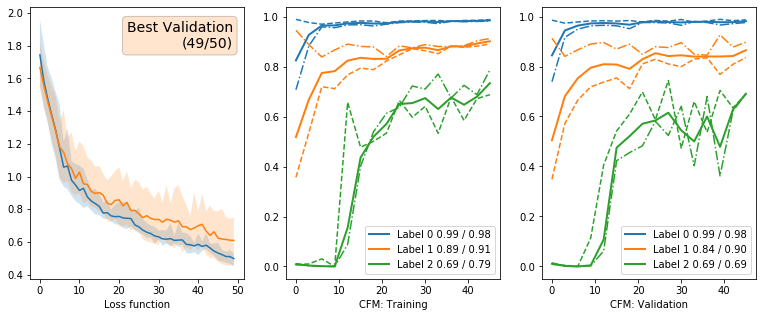

<IPython.core.display.Javascript object>

In [7]:
instance.run()
instance.logger.plot()

In [8]:
segmenter_transfer = Segmenter(
    AmiraLoaderx100,
    RandomBlockProcessor,
    UNet3D,
    CrossEntropyLoss_DiceLoss,
    loader_args,
    processor_args,
    model_args,
    crit_args,
    settings,
)
segmenter_transfer.folder = working_directory
segmenter_transfer.fold = 0

instance_transfer = segmenter_transfer.sxtcnn(0)
instance_transfer.settings.reset = True
instance_transfer._init_data()


<IPython.core.display.Javascript object>

### Transfer

In [9]:
base_params = instance_base.model.named_parameters()
params_dict = dict(instance_transfer.model.named_parameters())
for name_base, param_base in base_params:
    if name_base in params_dict:
        if param_base.shape == params_dict[name_base].shape:
            params_dict[name_base].data.copy_(param_base.data)
            print(f"Copied {name_base}")

Copied down_convs.0.block1.conv.weight
Copied down_convs.0.block1.conv.bias
Copied down_convs.0.block2.conv.weight
Copied down_convs.0.block2.conv.bias
Copied down_convs.1.block1.conv.weight
Copied down_convs.1.block1.conv.bias
Copied down_convs.1.block2.conv.weight
Copied down_convs.1.block2.conv.bias
Copied down_convs.2.block1.conv.weight
Copied down_convs.2.block1.conv.bias
Copied down_convs.2.block2.conv.weight
Copied down_convs.2.block2.conv.bias
Copied up_convs.0.upconv.weight
Copied up_convs.0.upconv.bias
Copied up_convs.0.block1.conv.weight
Copied up_convs.0.block1.conv.bias
Copied up_convs.0.block2.conv.weight
Copied up_convs.0.block2.conv.bias
Copied up_convs.1.upconv.weight
Copied up_convs.1.upconv.bias
Copied up_convs.1.block1.conv.weight
Copied up_convs.1.block1.conv.bias
Copied up_convs.1.block2.conv.weight
Copied up_convs.1.block2.conv.bias


<IPython.core.display.Javascript object>

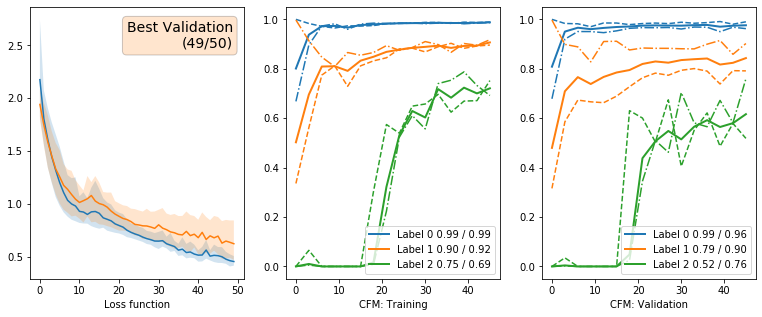

<IPython.core.display.Javascript object>

In [10]:
instance_transfer.run()
instance_transfer.logger.plot()


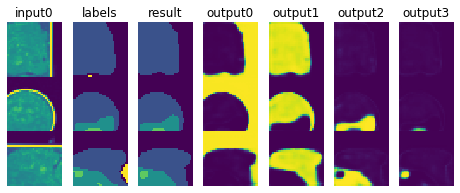

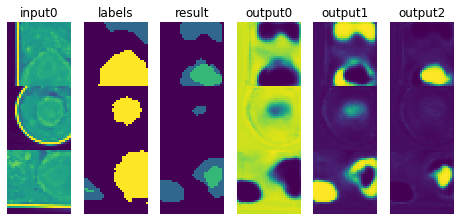

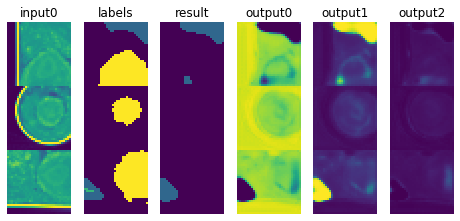

<IPython.core.display.Javascript object>

In [11]:
instance_base.show_training_data()
instance.show_training_data()
instance_transfer.show_training_data()

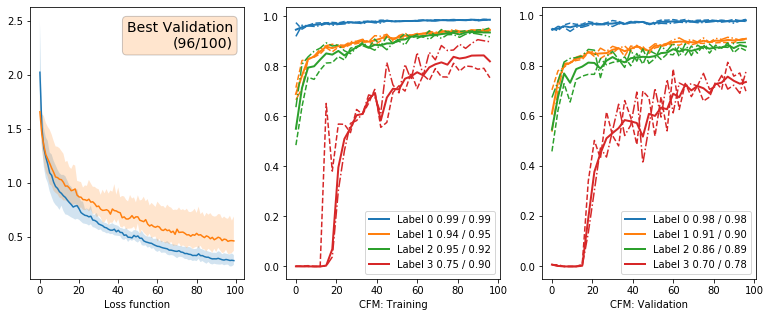

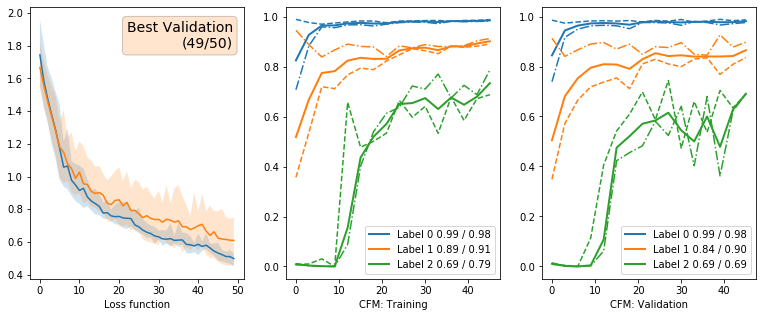

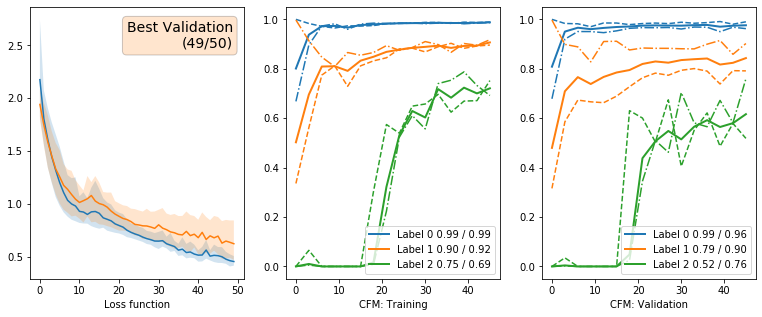

<IPython.core.display.Javascript object>

In [12]:
instance_base.logger.plot()
instance.logger.plot()
instance_transfer.logger.plot()

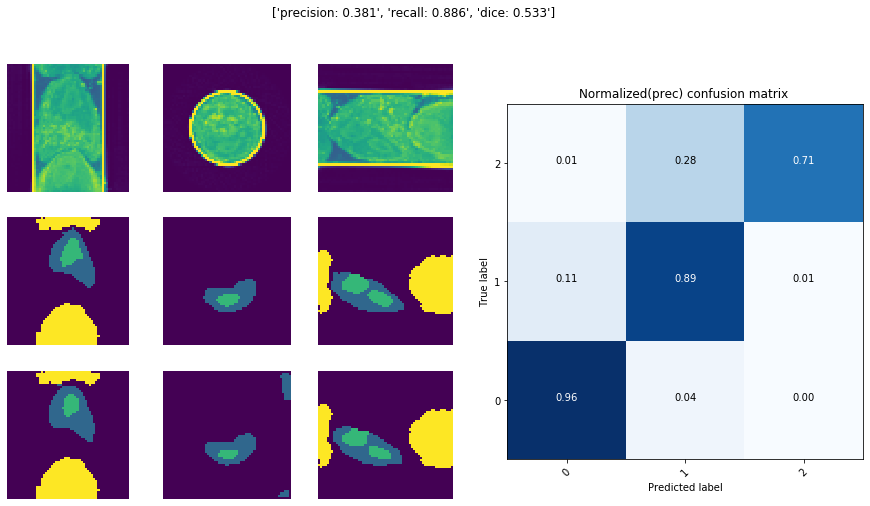

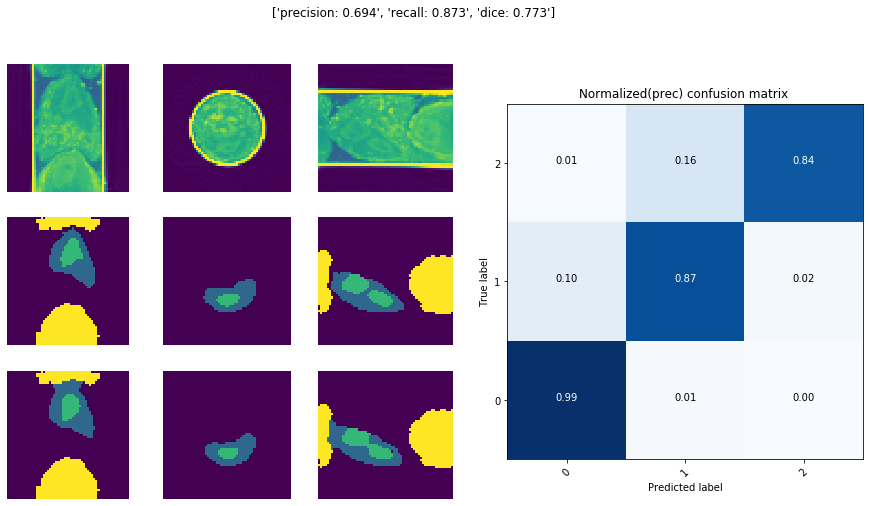

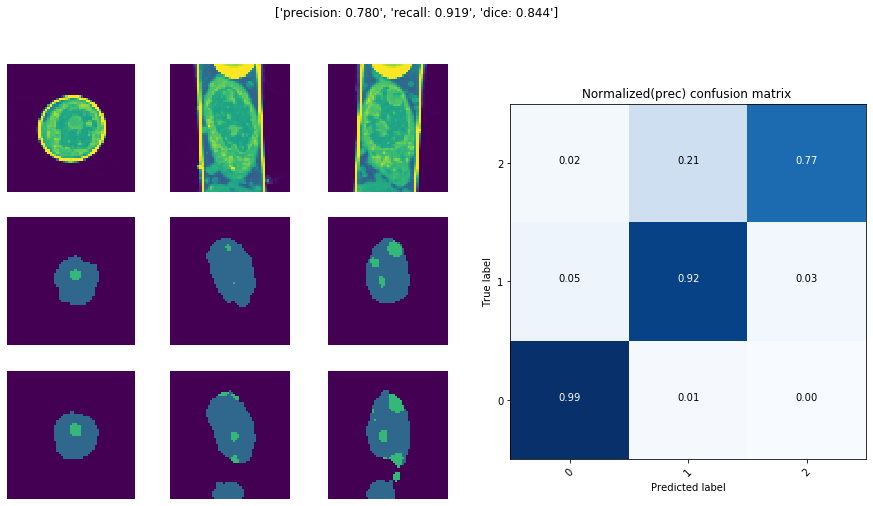

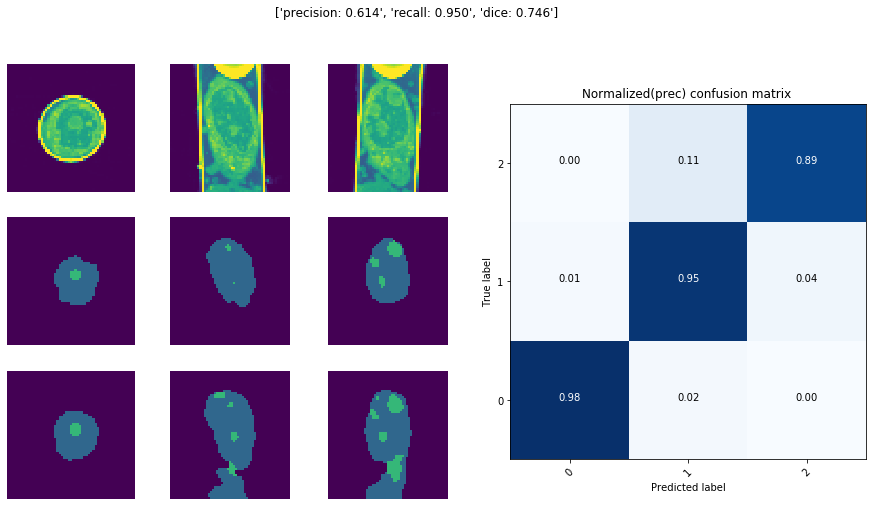

<IPython.core.display.Javascript object>

In [14]:
for index in instance.valid_idx:
    _ = instance.evaluate_sample(index, plot=True)
    _ = instance_transfer.evaluate_sample(index, plot=True)